<a href="https://colab.research.google.com/github/GiovaniAngeloGitHub/Estudos/blob/main/TrackUSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📦 Instalando/atualizando: librosa==0.10.2.post1, soundfile==0.12.1, scikit-learn==1.6.0, matplotlib==3.9.2, scipy==1.14.1, pandas==2.2.3
🚀 INICIANDO ANÁLISE COM VALIDAÇÃO
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 Carregando anotações de: /content/drive/MyDrive/ICe/TrackUSF/F1N1-F1C-P14_part1.wav.csv
📊 Total de marcações: 62
   - Vocalizações: 46 (74.2%)
   - Não-vocalizações: 16 (25.8%)

📈 Distribuição por tipo:
   - Vocalização tipo J: 19
   - Não-vocalização: 16
   - Vocalização tipo K: 13
   - Vocalização tipo F: 5
   - Vocalização tipo L: 3
   - Vocalização tipo G: 3
   - Vocalização tipo C: 2
   - Vocalização tipo D: 1
🎵 Carregando áudio de: /content/drive/MyDrive/ICe/TrackUSF/F1N1-F1C-P14_part1.wav
✅ Áudio carregado com sucesso (SR: 250000 Hz)

📊 Total de fragmentos: 2083
🔍 USFs detectados: 313 (threshold = 2.66853e-02)

📈 MÉTRICAS DE VALIDAÇÃO:
Precisão: 0.962
Recall: 0.732
F1-Score: 0.831



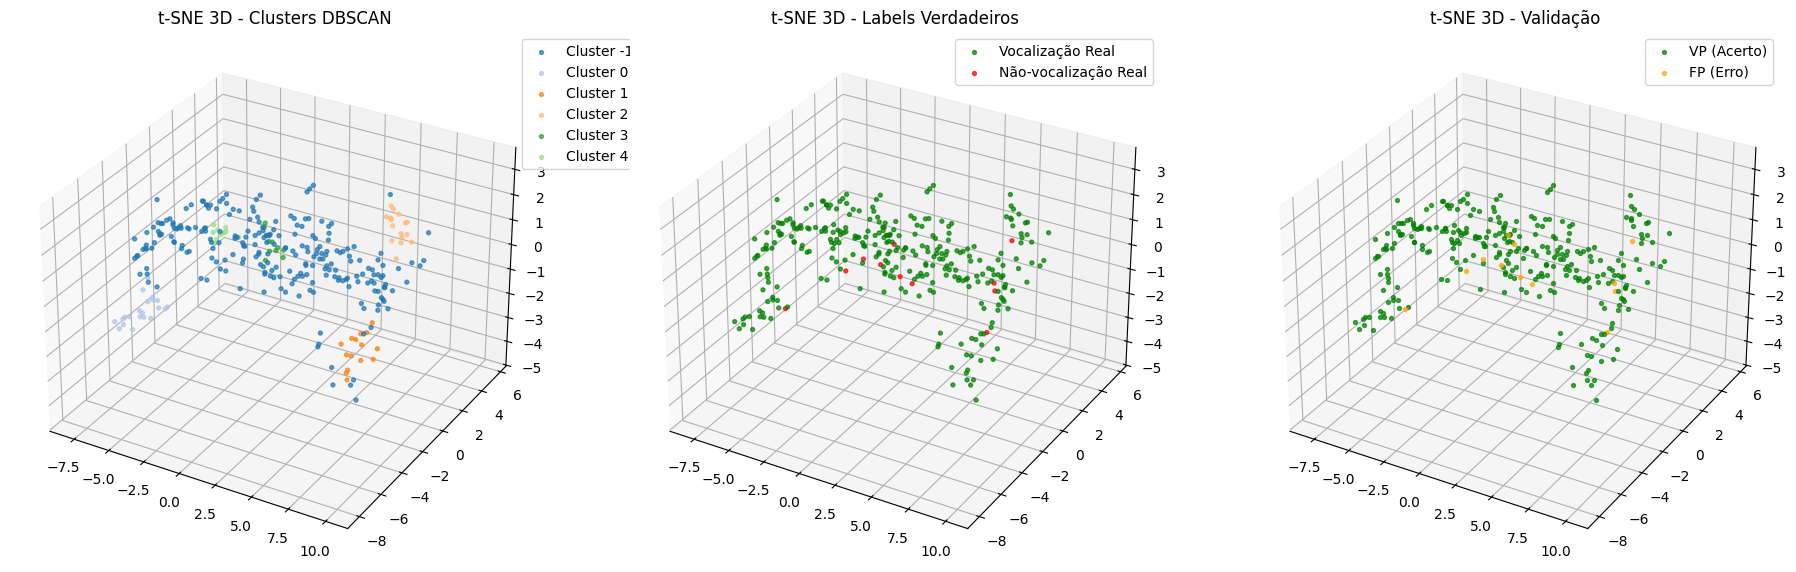

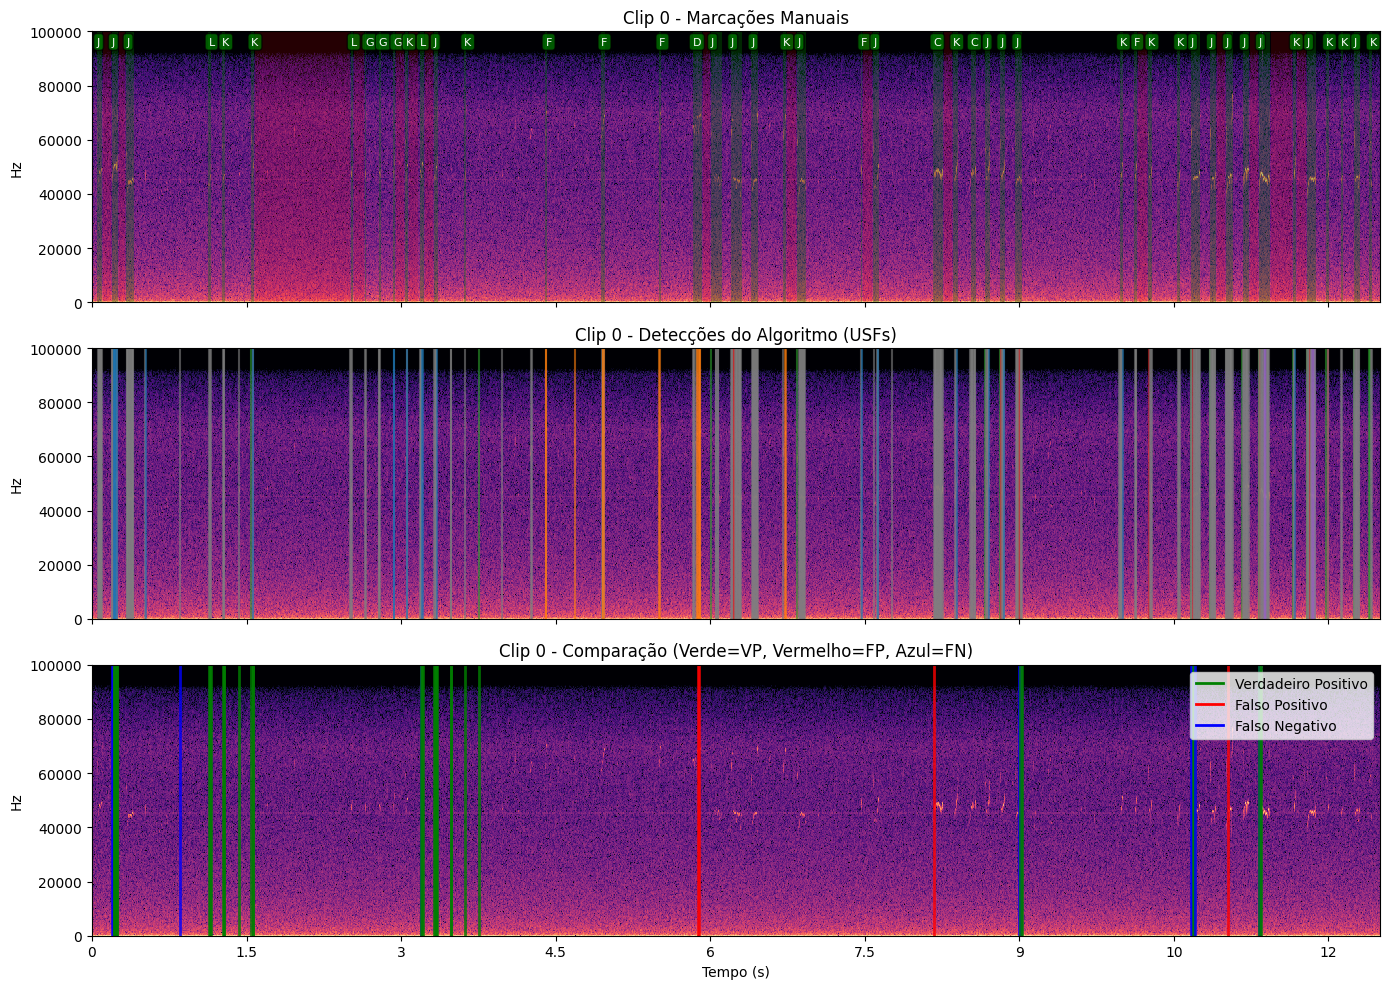


🏁 ANÁLISE CONCLUÍDA!


In [1]:
# TrackUSF-like pipeline (Colab-ready) - COM VALIDAÇÃO DE MARCAÇÕES
# Executar no Google Colab (ou qualquer Jupyter). Requer: librosa, soundfile, sklearn, matplotlib, scipy.
# Implementa: pool clips -> fragmentos 6 ms -> 15 kHz HP -> selecionar fragments por potência -> 15-100 kHz PSD -> 16 MFCCs -> t-SNE 3D -> DBSCAN -> overlay em spectrogram

import importlib
import sys
import subprocess
import pandas as pd

# Especificações de versão recomendadas
required_libs = {
    "librosa": "0.10.2.post1",
    "soundfile": "0.12.1",
    "scikit-learn": "1.6.0",
    "matplotlib": "3.9.2",
    "scipy": "1.14.1",
    "pandas": "2.2.3"
}

# Verifica e instala apenas as ausentes ou desatualizadas
missing_libs = []
for lib, version in required_libs.items():
    try:
        mod = importlib.import_module(lib.replace("-", "_"))
    except ImportError:
        missing_libs.append(f"{lib}=={version}")
    else:
        try:
            installed_version = mod.__version__
            if installed_version != version:
                missing_libs.append(f"{lib}=={version}")
        except AttributeError:
            pass

if missing_libs:
    print(f"📦 Instalando/atualizando: {', '.join(missing_libs)}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing_libs, "-q"])
else:
    print("✅ Todas as bibliotecas já estão nas versões recomendadas.")

# --- Imports após garantir versões ---
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import butter, sosfiltfilt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from google.colab import drive

# ---------------------------
# PARAMETERS (ajuste aqui)
SR = 250000
FRAG_MS = 6
HP_CUTOFF = 15000
PSD_MIN_F = 15000
PSD_MAX_F = 100000
N_MFCC = 16
N_MELS = 64
TSNE_PERPLEXITY = 30
TSNE_N_ITER = 1000
DBSCAN_EPS = 1.0
DBSCAN_MIN_SAMPLES = 10
THRESH_TYPE = "percentile"
THRESH_VALUE = 85

# ---------------------------
# FUNÇÕES PARA CARREGAR E PROCESSAR MARCAÇÕES
# ---------------------------

def load_annotations(csv_path):
    """Carrega as anotações do arquivo CSV"""
    print(f"📄 Carregando anotações de: {csv_path}")
    df = pd.read_csv(csv_path)

    # Cria uma coluna binária: 1 para vocalização (não-X), 0 para não-vocalização (X)
    df['is_vocalization'] = df['label'].apply(lambda x: 0 if x == 'X' else 1)

    # Estatísticas das marcações
    total_annotations = len(df)
    vocalizations = df['is_vocalization'].sum()
    non_vocalizations = total_annotations - vocalizations

    print(f"📊 Total de marcações: {total_annotations}")
    print(f"   - Vocalizações: {vocalizations} ({vocalizations/total_annotations*100:.1f}%)")
    print(f"   - Não-vocalizações: {non_vocalizations} ({non_vocalizations/total_annotations*100:.1f}%)")

    # Contagem por tipo de vocalização
    label_counts = df['label'].value_counts()
    print(f"\n📈 Distribuição por tipo:")
    for label, count in label_counts.items():
        label_type = "Não-vocalização" if label == 'X' else f"Vocalização tipo {label}"
        print(f"   - {label_type}: {count}")

    return df

def get_fragment_labels(fragment_times, annotations_df):
    """
    Determina o label de cada fragmento baseado nas anotações.
    Retorna array onde 1 = vocalização, 0 = não-vocalização
    """
    labels = []

    for clip_idx, frag_start in fragment_times:
        frag_end = frag_start + (FRAG_MS / 1000)

        # Verifica overlap com anotações
        is_vocalization = False
        for _, row in annotations_df.iterrows():
            ann_start = row['onset_s']
            ann_end = row['offset_s']

            # Verifica se há overlap
            if not (frag_end <= ann_start or frag_start >= ann_end):
                # Há overlap - verifica o tipo
                if row['is_vocalization'] == 1:
                    is_vocalization = True
                    break

        labels.append(1 if is_vocalization else 0)

    return np.array(labels)

def calculate_metrics(true_labels, predicted_labels):
    """Calcula métricas de avaliação"""
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='binary', pos_label=1
    )

    # Matriz de confusão
    cm = confusion_matrix(true_labels, predicted_labels)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

def plot_spectrogram_with_annotations(sig, sr, title, annotations_df=None,
                                      usf_times=None, usf_clusters=None,
                                      true_labels=None, predicted_labels=None):
    """Plota espectrograma com marcações manuais e detecções do algoritmo"""

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    # Calcular espectrograma
    n_fft = 1024
    hop_length = 256
    S = librosa.stft(sig.astype(np.float32), n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Plot 1: Espectrograma com marcações manuais
    ax = axes[0]
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='hz', ax=ax)
    ax.set_ylim(0, 100000)
    ax.set_title(f"{title} - Marcações Manuais")
    ax.set_xlabel("")

    # Adicionar marcações manuais como retângulos
    if annotations_df is not None:
        for _, row in annotations_df.iterrows():
            color = 'green' if row['is_vocalization'] == 1 else 'red'
            alpha = 0.3 if row['is_vocalization'] == 1 else 0.15
            rect = patches.Rectangle((row['onset_s'], 0),
                                    row['offset_s'] - row['onset_s'],
                                    100000,
                                    linewidth=0, facecolor=color, alpha=alpha)
            ax.add_patch(rect)

            # Adicionar label no topo
            if row['is_vocalization'] == 1:
                ax.text(row['onset_s'], 95000, row['label'],
                       fontsize=8, color='white',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.7))

    # Plot 2: Espectrograma com detecções do algoritmo
    ax = axes[1]
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='hz', ax=ax)
    ax.set_ylim(0, 100000)
    ax.set_title(f"{title} - Detecções do Algoritmo (USFs)")
    ax.set_xlabel("")

    # Adicionar detecções do algoritmo
    if usf_times is not None and usf_clusters is not None:
        cmap = plt.colormaps.get_cmap('tab10')
        for i, t in enumerate(usf_times):
            color = cmap(usf_clusters[i] % 10) if usf_clusters[i] != -1 else 'gray'
            ax.axvline(t, color=color, alpha=0.6, linewidth=1.5)

    # Plot 3: Comparação direta
    ax = axes[2]
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='hz', ax=ax)
    ax.set_ylim(0, 100000)
    ax.set_title(f"{title} - Comparação (Verde=VP, Vermelho=FP, Azul=FN)")
    ax.set_xlabel("Tempo (s)")

    # Adicionar comparação
    if true_labels is not None and predicted_labels is not None and usf_times is not None:
        for i, t in enumerate(usf_times):
            if i < len(true_labels) and i < len(predicted_labels):
                if true_labels[i] == 1 and predicted_labels[i] == 1:
                    color = 'green'  # Verdadeiro Positivo
                elif true_labels[i] == 0 and predicted_labels[i] == 1:
                    color = 'red'    # Falso Positivo
                elif true_labels[i] == 1 and predicted_labels[i] == 0:
                    color = 'blue'   # Falso Negativo
                else:
                    continue  # Verdadeiro Negativo (não plotar)

                ax.axvline(t, color=color, alpha=0.8, linewidth=2)

    # Adicionar legenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='green', lw=2, label='Verdadeiro Positivo'),
        Line2D([0], [0], color='red', lw=2, label='Falso Positivo'),
        Line2D([0], [0], color='blue', lw=2, label='Falso Negativo')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.show()

# ---------------------------
# FUNÇÕES ORIGINAIS (mantidas)
# ---------------------------

def hp_filter(sig, sr, cutoff=15000, order=4):
    sos = butter(order, cutoff, btype='highpass', fs=sr, output='sos')
    return sosfiltfilt(sos, sig)

def split_fragments(sig, sr, frag_ms=6):
    frag_len = int(sr * frag_ms / 1000)
    n_frags = int(np.floor(len(sig) / frag_len))
    fragments = sig[:n_frags*frag_len].reshape(n_frags, frag_len)
    starts = (np.arange(n_frags) * frag_len) / sr
    return fragments, starts

def fragment_power(frags):
    return np.sqrt(np.mean(frags**2, axis=1))

def fragment_mfcc(frags, sr, n_mfcc=16, n_mels=64, fmin=15000, fmax=100000):
    mfccs = []
    for frag in frags:
        y = frag.astype(np.float32)
        frag_len = len(y)
        n_fft = 1
        while n_fft*2 <= frag_len:
            n_fft *= 2
        n_fft = max(256, n_fft)
        hop_length = max(1, n_fft // 4)
        S_mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc,
                                      n_fft=n_fft, hop_length=hop_length,
                                      n_mels=n_mels, fmin=fmin, fmax=fmax)
        vec = np.mean(S_mfcc, axis=1)
        mfccs.append(vec)
    return np.vstack(mfccs)

def load_audio_file(audio_path, sr):
    print(f"🎵 Carregando áudio de: {audio_path}")
    try:
        clip, current_sr = librosa.load(audio_path, sr=sr)
        print(f"✅ Áudio carregado com sucesso (SR: {current_sr} Hz)")
        return clip
    except Exception as e:
        print(f"❌ Erro ao carregar arquivo de áudio: {e}")
        return None

# ---------------------------
# PIPELINE MODIFICADO COM VALIDAÇÃO
# ---------------------------

def run_pipeline_with_validation(clips, sr, annotations_df, frag_ms, hp_cutoff,
                                 psd_min_f, psd_max_f, n_mfcc, n_mels,
                                 tsne_perplexity, tsne_n_iter, dbscan_eps,
                                 dbscan_min_samples, thresh_type, thresh_value):

    if not clips:
        print("❌ Nenhum clip de áudio fornecido.")
        return

    # Processar fragmentos
    all_frag_mfcc, all_frag_times, all_frag_powers, frag_clip_idx = [], [], [], []

    for idx, clip in enumerate(clips):
        clip_hp = hp_filter(clip, sr, cutoff=hp_cutoff, order=6)
        frags, starts = split_fragments(clip_hp, sr, frag_ms=frag_ms)
        powers = fragment_power(frags)
        all_frag_powers.append(powers)
        mfccs = fragment_mfcc(frags, sr=sr, n_mfcc=n_mfcc, n_mels=n_mels,
                              fmin=psd_min_f, fmax=psd_max_f)
        all_frag_mfcc.append(mfccs)
        for s in starts:
            all_frag_times.append((idx, s))
        frag_clip_idx.extend([idx]*len(frags))

    all_frag_mfcc = np.vstack(all_frag_mfcc)
    all_frag_powers = np.hstack(all_frag_powers)

    print(f"\n📊 Total de fragmentos: {all_frag_mfcc.shape[0]}")

    # Obter labels verdadeiros dos fragmentos
    true_fragment_labels = get_fragment_labels(all_frag_times, annotations_df)

    # Selecionar USFs baseado no threshold
    if thresh_type == "percentile":
        thresh = np.percentile(all_frag_powers, thresh_value)
    elif thresh_type == "zscore":
        mean_p, std_p = np.mean(all_frag_powers), np.std(all_frag_powers)
        thresh = mean_p + thresh_value * std_p
    else:
        thresh = thresh_value

    is_usf = all_frag_powers >= thresh
    predicted_fragment_labels = is_usf.astype(int)

    print(f"🔍 USFs detectados: {np.sum(is_usf)} (threshold = {thresh:.5e})")

    # Calcular métricas
    print("\n📈 MÉTRICAS DE VALIDAÇÃO:")
    print("="*50)

    metrics = calculate_metrics(true_fragment_labels, predicted_fragment_labels)

    print(f"Precisão: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1-Score: {metrics['f1']:.3f}")

    print(f"\n📊 Matriz de Confusão:")
    print(f"                 Predito")
    print(f"                 Não-Voc  Voc")
    print(f"Real Não-Voc    {metrics['confusion_matrix'][0,0]:5d}  {metrics['confusion_matrix'][0,1]:5d}")
    print(f"Real Voc        {metrics['confusion_matrix'][1,0]:5d}  {metrics['confusion_matrix'][1,1]:5d}")

    # Estatísticas adicionais
    tp = metrics['confusion_matrix'][1,1]
    fp = metrics['confusion_matrix'][0,1]
    tn = metrics['confusion_matrix'][0,0]
    fn = metrics['confusion_matrix'][1,0]

    print(f"\n📊 Detalhamento:")
    print(f"Verdadeiros Positivos (VP): {tp}")
    print(f"Falsos Positivos (FP): {fp}")
    print(f"Verdadeiros Negativos (VN): {tn}")
    print(f"Falsos Negativos (FN): {fn}")

    if np.sum(is_usf) == 0:
        print("\n⚠️ Nenhum USF detectado acima do threshold. Ajuste os parâmetros.")
        return metrics

    # Continuar com t-SNE e DBSCAN apenas para USFs detectados
    usf_mfcc = all_frag_mfcc[is_usf]
    usf_meta = np.array(all_frag_times)[is_usf]
    usf_powers = all_frag_powers[is_usf]
    usf_clipidx = np.array(frag_clip_idx)[is_usf]
    usf_true_labels = true_fragment_labels[is_usf]

    # Normalizar features
    scaler = StandardScaler()
    usf_mfcc_z = scaler.fit_transform(usf_mfcc)

    print("\n🧮 Executando t-SNE...")
    tsne = TSNE(n_components=3, perplexity=min(tsne_perplexity, usf_mfcc_z.shape[0]-1),
                max_iter=tsne_n_iter, init='pca', random_state=0)
    usf_emb = tsne.fit_transform(usf_mfcc_z)

    # DBSCAN clustering
    db = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples).fit(usf_emb)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"🔍 Clusters DBSCAN encontrados: {n_clusters} (incluindo ruído -1)")

    # Análise de clusters vs. vocalizações reais
    print("\n📊 Análise de Clusters vs. Vocalizações Reais:")
    unique_clusters = np.unique(labels)
    for cluster_id in unique_clusters:
        cluster_mask = labels == cluster_id
        cluster_true_labels = usf_true_labels[cluster_mask]
        n_voc = np.sum(cluster_true_labels == 1)
        n_non_voc = np.sum(cluster_true_labels == 0)
        total = len(cluster_true_labels)

        cluster_name = f"Cluster {cluster_id}" if cluster_id != -1 else "Ruído"
        print(f"{cluster_name}: {n_voc}/{total} vocalizações ({n_voc/total*100:.1f}%), "
              f"{n_non_voc}/{total} não-vocalizações ({n_non_voc/total*100:.1f}%)")

    # Plot t-SNE 3D com cores baseadas nos labels verdadeiros
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(18, 6))

    # Plot 1: Colorido por clusters DBSCAN
    ax1 = fig.add_subplot(131, projection='3d')
    colors = plt.colormaps.get_cmap('tab20')
    for lab in unique_clusters:
        mask = (labels == lab)
        color = colors(np.where(unique_clusters == lab)[0] % 20)
        ax1.scatter(usf_emb[mask,0], usf_emb[mask,1], usf_emb[mask,2],
                   s=8, alpha=0.7, label=f"Cluster {lab}", c=[color])
    ax1.set_title("t-SNE 3D - Clusters DBSCAN")
    ax1.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

    # Plot 2: Colorido por labels verdadeiros
    ax2 = fig.add_subplot(132, projection='3d')
    voc_mask = usf_true_labels == 1
    non_voc_mask = usf_true_labels == 0
    ax2.scatter(usf_emb[voc_mask,0], usf_emb[voc_mask,1], usf_emb[voc_mask,2],
               s=8, alpha=0.7, c='green', label='Vocalização Real')
    ax2.scatter(usf_emb[non_voc_mask,0], usf_emb[non_voc_mask,1], usf_emb[non_voc_mask,2],
               s=8, alpha=0.7, c='red', label='Não-vocalização Real')
    ax2.set_title("t-SNE 3D - Labels Verdadeiros")
    ax2.legend()

    # Plot 3: Comparação (acertos e erros)
    ax3 = fig.add_subplot(133, projection='3d')

    # Para cada ponto USF, verificar se foi corretamente classificado
    used_labels = set()  # evita duplicar rótulos na legenda

    for i in range(len(usf_true_labels)):
        if usf_true_labels[i] == 1:  # É vocalização real
            color = 'green'
            label = 'VP (Acerto)'
        else:  # Não é vocalização real
            color = 'orange'
            label = 'FP (Erro)'

        # Adiciona label apenas uma vez
        show_label = label not in used_labels
        if show_label:
            used_labels.add(label)

        ax3.scatter(
            usf_emb[i, 0], usf_emb[i, 1], usf_emb[i, 2],
            s=8, alpha=0.7, c=color,
            label=label if show_label else None
        )

    ax3.set_title("t-SNE 3D - Validação")
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # Plotar espectrograma com comparação
    for clip_idx, clip in enumerate(clips):
        sel = (usf_clipidx == clip_idx)
        times = usf_meta[sel][:,1].astype(float)
        labs = labels[sel]

        # Obter todos os tempos de fragmentos para este clip
        all_clip_times = [t for (c, t) in all_frag_times if c == clip_idx]

        title = f"Clip {clip_idx}"
        plot_spectrogram_with_annotations(
            clip, sr, title,
            annotations_df=annotations_df,
            usf_times=times,
            usf_clusters=labs,
            true_labels=true_fragment_labels[:len(all_clip_times)],
            predicted_labels=predicted_fragment_labels[:len(all_clip_times)]
        )

    return metrics

# ---------------------------
# EXECUÇÃO PRINCIPAL
# ---------------------------

if __name__ == "__main__":
    print("🚀 INICIANDO ANÁLISE COM VALIDAÇÃO")
    print("="*60)

    # Montar Google Drive
    drive.mount('/content/drive')

    # Caminhos dos arquivos
    audio_file_path = '/content/drive/MyDrive/ICe/TrackUSF/F1N1-F1C-P14_part1.wav'
    csv_file_path = '/content/drive/MyDrive/ICe/TrackUSF/F1N1-F1C-P14_part1.wav.csv'

    # Carregar anotações
    annotations_df = load_annotations(csv_file_path)

    # Carregar áudio
    user_clip = load_audio_file(audio_file_path, SR)

    if user_clip is not None:
        # Executar pipeline com validação
        metrics = run_pipeline_with_validation(
            [user_clip], SR, annotations_df,
            FRAG_MS, HP_CUTOFF, PSD_MIN_F, PSD_MAX_F,
            N_MFCC, N_MELS, TSNE_PERPLEXITY, TSNE_N_ITER,
            DBSCAN_EPS, DBSCAN_MIN_SAMPLES, THRESH_TYPE, THRESH_VALUE
        )

        print("\n"+"="*60)
        print("🏁 ANÁLISE CONCLUÍDA!")
        print("="*60)

        # Sugestões de otimização
        if metrics and metrics['f1'] < 0.5:
            print("\n💡 SUGESTÕES DE OTIMIZAÇÃO:")
            print("-"*40)
            if metrics['precision'] < 0.5:
                print("• Precisão baixa: Muitos falsos positivos")
                print("  → Tente aumentar THRESH_VALUE (atual: {})".format(THRESH_VALUE))
                print("  → Ou ajustar DBSCAN_EPS para ser mais restritivo")
            if metrics['recall'] < 0.5:
                print("• Recall baixo: Muitas vocalizações não detectadas")
                print("  → Tente diminuir THRESH_VALUE (atual: {})".format(THRESH_VALUE))
                print("  → Ou ajustar os parâmetros do filtro passa-altas")
            print("\nOutros ajustes possíveis:")
            print("• Modificar FRAG_MS (atual: {} ms)".format(FRAG_MS))
            print("• Ajustar faixa de frequência PSD_MIN_F - PSD_MAX_F")
            print("• Experimentar diferentes valores de DBSCAN_EPS e DBSCAN_MIN_SAMPLES")
    else:
        print("❌ Não foi possível carregar o arquivo de áudio.")